# Reference Notebook

- [Stop the S@#$ - Toxic Comments EDA](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda)

- [EDA : Toxic Comment Classification Challenge](https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge)

- [Toxic Exploration](https://www.kaggle.com/madcap/toxic-exploration)

# 대회 설명

## 목적

## 데이터 설명

# 패키지 및 데이터 준비

In [2]:
import pandas as pd 
import numpy as np

import time
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("dataset/toxic-comment-classification/train.csv")
test = pd.read_csv("dataset/toxic-comment-classification/test.csv")

In [4]:
print(train.info())
train.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


# EDA

## Class Imbalance

train 데이터셋의 클래스 불균형한지에 대한 여부를 확인해보자.

In [5]:
# one-hot encoding 형태로 toxic label이 체크된 comment
toxic_onehot_labels = train.iloc[:, 2:]

# 그 어느 toxic label도 체크되지 않은 clean comment 확인하기
rowsums = toxic_onehot_labels.sum(axis=1)
train['clean'] = (rowsums==0)

print("Total comments: ", len(train))
print("Total clean comments: ", train['clean'].sum())
print("Total toxic comment tags: ", toxic_onehot_labels.sum().sum())

Total comments:  159571
Total clean comments:  143346
Total toxic comment tags:  35098


In [10]:
print("Check for missing values in Train dataset")
null_check_train = train.isnull().sum()
print(null_check_train, "\n")

print("Check for missing values in Test dataset")
null_check_test = test.isnull().sum()
print(null_check_test, "\n")

# Fill NA with "unknown" string
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64 

Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64 



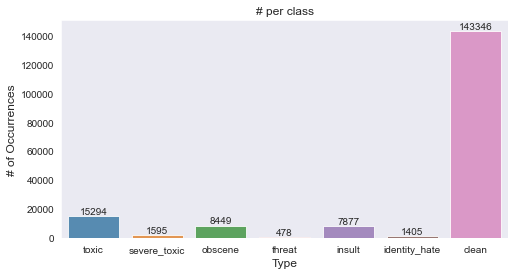

In [11]:
# Plotting counts per category

x = train.iloc[:,2:].sum()
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)

plt.title("# per class")
plt.ylabel("# of Occurrences", fontsize=12)
plt.xlabel("Type", fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2,
        height + 5,
        label, 
        ha='center',
        va="bottom"
    )
    
plt.show()

### 관찰 결과

- 각 class에 할당된 comment의 수가 균일한 분포를 띄고 있지 않다. 따라서 class imbalance 문제를 맞닥뜨릴 수 있다.
- 전체 train 데이터셋은 약 약 159k 건, 그런데 toxic comment tag 수는 약 35k 건, clean comment 수는 약 143건.
    - Multi-tagging이 있으므로 가능하다. 즉, 각 class가 서로 exclusive한 multi-class문제가 아닌 1건의 comment가 1개 이상의 class를 가지느 multi-label문제일 가능성이 있다.

## Multi-tagging

percentile for each tag count:
0    0.898321
1    0.039857
3    0.026377
2    0.021808
4    0.011030
5    0.002413
6    0.000194
dtype: float64


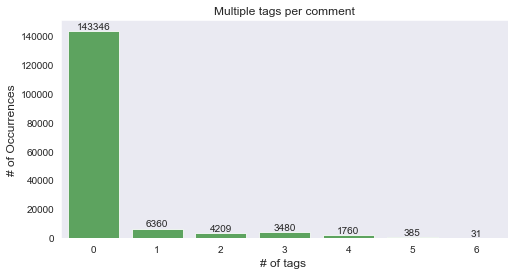

In [33]:
print("percentile for each tag count:")
print(rowsums.value_counts('per'))
x = rowsums.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

- 2개 이상의 label이 태깅된 comment가 있음을 확인할 수 있다.

## Crosstab

In [9]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags

def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out